# モデルの訓練
画像識別アプリで使用する、CNNのモデルを訓練し保存します。  
今回は訓練データにCIFAR-10を使用します。  


## データの前処理
CIFAR-10を読み込んで、データ拡張とともにDataLoaderの設定を行います。  

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 41640713.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## モデルの構築
`nn.Module`モジュールを継承したクラスとして、CNNのモデルを構築します。   

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 学習
モデルを訓練します。   
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。


In [ ]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = iter(test_loader).__next__()
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.819433772045633 Loss_Test: 1.570582628250122
Epoch: 1 Loss_Train: 1.6060619099670663 Loss_Test: 1.4592304229736328
Epoch: 2 Loss_Train: 1.5327922079874121 Loss_Test: 1.39482581615448
Epoch: 3 Loss_Train: 1.4748575214839652 Loss_Test: 1.3511543273925781
Epoch: 4 Loss_Train: 1.444275649002446 Loss_Test: 1.3197811841964722
Epoch: 5 Loss_Train: 1.4080235096804625 Loss_Test: 1.277523398399353
Epoch: 6 Loss_Train: 1.3909057827709277 Loss_Test: 1.254417061805725
Epoch: 7 Loss_Train: 1.3658400639853514 Loss_Test: 1.2691415548324585
Epoch: 8 Loss_Train: 1.3472924274404336 Loss_Test: 1.2441258430480957
Epoch: 9 Loss_Train: 1.3304410958686448 Loss_Test: 1.2298259735107422
Epoch: 10 Loss_Train: 1.3189237779363647 Loss_Test: 1.2094337940216064
Epoch: 11 Loss_Train: 1.3091501896186253 Loss_Test: 1.1828184127807617
Epoch: 12 Loss_Train: 1.3038027656200293 Loss_Test: 1.167615532875061
Epoch: 13 Loss_Train: 1.2959875131354612 Loss_Test: 1.154312252998352
Epoch: 14 Loss_Train: 1.2

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

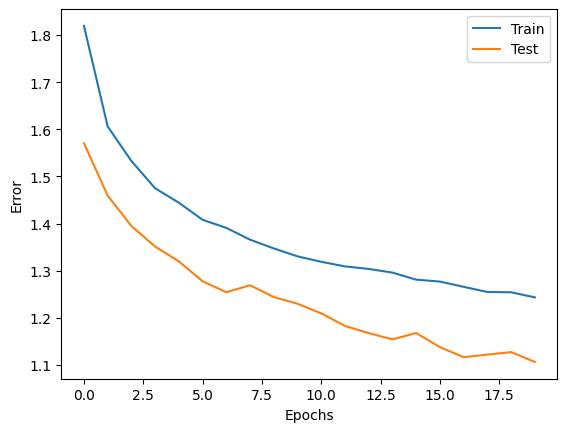

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [ ]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 61.309999999999995%


## モデルの保存
訓練済みモデルのパラメータを保存します。    
`state_dict()`によりモデルの各パラメータが取得できるので、これを保存します。

In [ ]:
import torch

# state_dict()の表示
for key in net.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

# 保存
torch.save(net.state_dict(), "model_cnn.pth")

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[ 0.1420, -0.0084, -0.2346, -0.0915,  0.0774],
         [-0.0520,  0.0659, -0.1443, -0.0641, -0.0756],
         [-0.0421, -0.0944,  0.0991,  0.1139,  0.0302],
         [ 0.0920,  0.1326,  0.0894,  0.0616,  0.0509],
         [ 0.1411,  0.0463,  0.0305,  0.0908,  0.1508]],

        [[-0.0358, -0.1325, -0.0995, -0.1584,  0.0292],
         [ 0.0787, -0.1813, -0.0261, -0.0908, -0.0376],
         [-0.1347, -0.0212, -0.0424,  0.0761, -0.0323],
         [-0.1967, -0.0418, -0.0103,  0.1710,  0.0667],
         [ 0.0047, -0.0083,  0.1032, -0.1163, -0.0756]],

        [[-0.0431, -0.0810, -0.0586, -0.0513,  0.0716],
         [ 0.0920, -0.1042, -0.0490,  0.0379,  0.0357],
         [-0.1387, -0.0785,  0.1458,  0.0774,  0

## モデルの読み込み
保存したパラメータを読み込み、モデルに設定します。  
`torch.load()`で`map_location`にCPUを指定することで、GPUで訓練したモデルをCPUで使用することが可能になります。  


In [ ]:
# 読み込み
net_loaded = Net()
net_loaded.load_state_dict(torch.load("model_cnn.pth", map_location=torch.device("cpu")))  #CPU対応
net_loaded.eval()  # 評価モード

# state_dict()の表示
for key in net_loaded.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net_loaded.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[ 0.1420, -0.0084, -0.2346, -0.0915,  0.0774],
         [-0.0520,  0.0659, -0.1443, -0.0641, -0.0756],
         [-0.0421, -0.0944,  0.0991,  0.1139,  0.0302],
         [ 0.0920,  0.1326,  0.0894,  0.0616,  0.0509],
         [ 0.1411,  0.0463,  0.0305,  0.0908,  0.1508]],

        [[-0.0358, -0.1325, -0.0995, -0.1584,  0.0292],
         [ 0.0787, -0.1813, -0.0261, -0.0908, -0.0376],
         [-0.1347, -0.0212, -0.0424,  0.0761, -0.0323],
         [-0.1967, -0.0418, -0.0103,  0.1710,  0.0667],
         [ 0.0047, -0.0083,  0.1032, -0.1163, -0.0756]],

        [[-0.0431, -0.0810, -0.0586, -0.0513,  0.0716],
         [ 0.0920, -0.1042, -0.0490,  0.0379,  0.0357],
         [-0.1387, -0.0785,  0.1458,  0.0774,  0

モデルの各パラメータを保存し、読み込むことができました。